# Quora Question Pairs Kaggle Challenge

## Importing the csv

Import CSV and store selected rows in a list.

In [363]:
import csv
questions = []

with open('q_quora_100.csv', 'rb') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        questions.append(row[0:6])

Print the first row of the csv, the column keys. For double checking that the columns are the ones we want to easily refer back to see which columns are which.

In [364]:
keys = questions[0]
print 'column names'
print keys

column names
['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate']


Identify any columns that have the wrong number of columns. This was found because commas were used in some questions which messed up the csv parsing.

In [365]:
for row in questions:
    if len(row) != 6:
        print 'WARNING: A COLUMN NEEDS FIXING' + str(row[0])

Convert python list to numpy array and delete the column names.

In [366]:
import numpy as np

questions = np.array(questions)
questions = np.delete(questions, 0, 0)
print questions[0]

['0' '1' '2'
 'What is the step by step guide to invest in share market in india?'
 'What is the step by step guide to invest in share market?' '0']


## Data Exploration

First take a random entry in the dataset to get a feel for the questions.

In [369]:
import random
from IPython.display import HTML, display

size = len(questions)
random_index = random.randrange(size)
random_question = questions[random_index]


display(HTML(
    '<table><tr>{}</tr></table>'.format(
        '</tr><tr>'.join(
            '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in random_question)) for row in random_question)
        )
    )
)

6,13,14,Should I buy tiago?,What keeps childern active and far from phone and video games?,0
6,13,14,Should I buy tiago?,What keeps childern active and far from phone and video games?,0
6,13,14,Should I buy tiago?,What keeps childern active and far from phone and video games?,0
6,13,14,Should I buy tiago?,What keeps childern active and far from phone and video games?,0
6,13,14,Should I buy tiago?,What keeps childern active and far from phone and video games?,0
6,13,14,Should I buy tiago?,What keeps childern active and far from phone and video games?,0


Get a count of how many duplicates and what percentage.

In [370]:
duplicates = 0
not_duplicates = 0
total = len(questions)

for row in questions:
    if row[5] == '0':
        not_duplicates += 1
    else:
        duplicates += 1

print 'duplicates: ' + str(duplicates) + ' percentage: ' + str((float(duplicates) / float(total))) + '%'
print 'not duplicates: ' + str(not_duplicates) + ' percentage: ' + str(float(not_duplicates) / float(total)) + '%'

duplicates: 36 percentage: 0.349514563107%
not duplicates: 67 percentage: 0.650485436893%


## Bag of Words

### Munging

Downcase and then split the sentence into tokens.

In [371]:
import re
processing = []

for data in questions:
    pairId = data[0]
    sentence1 = data[3].lower()
    sentence2 = data[4].lower()
    tokens1 = sentence1.split(' ')
    tokens2 = sentence2.split(' ')
    processing.append([
        pairId,
        tokens1,
        tokens2
    ])
    
print(processing[0:4])

[['0', ['what', 'is', 'the', 'step', 'by', 'step', 'guide', 'to', 'invest', 'in', 'share', 'market', 'in', 'india?'], ['what', 'is', 'the', 'step', 'by', 'step', 'guide', 'to', 'invest', 'in', 'share', 'market?']], ['1', ['what', 'is', 'the', 'story', 'of', 'kohinoor', '(koh-i-noor)', 'diamond?'], ['what', 'would', 'happen', 'if', 'the', 'indian', 'government', 'stole', 'the', 'kohinoor', '(koh-i-noor)', 'diamond', 'back?']], ['2', ['how', 'can', 'i', 'increase', 'the', 'speed', 'of', 'my', 'internet', 'connection', 'while', 'using', 'a', 'vpn?'], ['how', 'can', 'internet', 'speed', 'be', 'increased', 'by', 'hacking', 'through', 'dns?']], ['3', ['why', 'am', 'i', 'mentally', 'very', 'lonely?', 'how', 'can', 'i', 'solve', 'it?'], ['find', 'the', 'remainder', 'when', '[math]23^{24}[/math]', 'is', 'divided', 'by', '24,23?']]]


We remove all stopwords and punctuation.

In [372]:
import nltk
from nltk.corpus import stopwords
munged = []

def remove_stop(sentence, words=stopwords.words('english')):
    remove_these = []
    for i in range(0, len(sentence) - 1):
        word = sentence[i]
        if word in words:
            remove_these.append(i)
    output = []
    for i in range(0, len(sentence)):
        if i not in remove_these:
            punctuationless = remove_punctuation(sentence[i])
            if len(punctuationless) > 0:
                output.append(punctuationless)
    return output

def remove_punctuation(word):
    return re.sub('[^a-zA-Z]', '', word)

for data in processing:
    pairId = data[0]
    sentence1 = data[1]
    sentence2 = data[2]
    out1 = remove_stop(sentence1)
    out2 = remove_stop(sentence2)
    munged.append([
        pairId,
        out1,
        out2
    ])
    
print munged[0:5]

[['0', ['step', 'step', 'guide', 'invest', 'share', 'market', 'india'], ['step', 'step', 'guide', 'invest', 'share', 'market']], ['1', ['story', 'kohinoor', 'kohinoor', 'diamond'], ['would', 'happen', 'indian', 'government', 'stole', 'kohinoor', 'kohinoor', 'diamond', 'back']], ['2', ['increase', 'speed', 'internet', 'connection', 'using', 'vpn'], ['internet', 'speed', 'increased', 'hacking', 'dns']], ['3', ['mentally', 'lonely', 'solve', 'it'], ['find', 'remainder', 'mathmath', 'divided']], ['4', ['one', 'dissolve', 'water', 'quikly', 'sugar', 'salt', 'methane', 'carbon', 'di', 'oxide'], ['fish', 'would', 'survive', 'salt', 'water']]]


/Users/alexbeeken/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


### Order words by popularity

We'll create a list of all words used in the corpus.

In [373]:
all_tokens = []

for row in munged:
    for word in row[1]:
        all_tokens.append(word)
    for word in row[2]:
        all_tokens.append(word)

print all_tokens[0:20]

['step', 'step', 'guide', 'invest', 'share', 'market', 'india', 'step', 'step', 'guide', 'invest', 'share', 'market', 'story', 'kohinoor', 'kohinoor', 'diamond', 'would', 'happen', 'indian']


Then we'll count the occurences of each word and order it by frequency.

In [374]:
VOCABULARY_MAX = 1000

from collections import Counter

count = Counter(all_tokens)
top_count = count.most_common(VOCABULARY_MAX)
print top_count[0:20]

[('best', 15), ('make', 12), ('learn', 8), ('much', 8), ('like', 8), ('would', 7), ('find', 6), ('ever', 6), ('india', 6), ('someone', 6), ('book', 6), ('quora', 5), ('phone', 5), ('me', 5), ('good', 5), ('effects', 5), ('increase', 5), ('get', 5), ('ask', 5), ('one', 5)]


Now we'll make the vocabulary count into a usable list.

In [375]:
vocabulary = []

for tup in top_count:
    vocabulary.append(tup[0])

print 'top 20 words: ' + str(vocabulary[0:20])
print '\nactual vocabulary size: ' + str(len(vocabulary))
print '\npercentage of original corpus: '+ str(float(len(vocabulary)) / float(len(count)) * 100) + '%'

top 20 words: ['best', 'make', 'learn', 'much', 'like', 'would', 'find', 'ever', 'india', 'someone', 'book', 'quora', 'phone', 'me', 'good', 'effects', 'increase', 'get', 'ask', 'one']

actual vocabulary size: 676

percentage of original corpus: 100.0%


In [376]:
VOCABULARY_SIZE = len(vocabulary)

Convert the actual strings in our data to indexes in the vocabulary list. Examine how many words are left out of our vocabulary with our vocabulary size.

In [377]:
indexes = []
noneCount = 0

def vocabIndex(token):
    try:
        return vocabulary.index(token)
    except ValueError:
        return None
        

def indexify(tokens):
    global noneCount
    output = []
    for token in tokens:
        index = vocabIndex(token)
        if index:
            output.append(index)
        else:
            noneCount += 1
    return output
        
for row in munged:
    indexes.append([
        row[0],
        indexify(row[1]),
        indexify(row[2])
    ])

print 'example: '
print indexes[0]
print '\ntotal none count: ' + str(noneCount)
print '\npercentage of corpus removed: ' + str(float(noneCount) / float(len(all_tokens)) * 100) + '%'

example: 
['0', [43, 43, 217, 283, 124, 110, 8], [43, 43, 217, 283, 124, 110]]

total none count: 15

percentage of corpus removed: 1.30548302872%


Seperate the dataset into a Training and Testing sets.

In [378]:
xTrain = []
yTrain = []
xTest = []
yTest = []
    
for index in indexes:
    if int(index[0]) < (len(indexes) / 4):
        xTest.append(index[1] + index[2])
    else:
        xTrain.append(index[1] + index[2])
        
for question in questions:
    if int(question[0]) < (len(questions) / 4):
        yTest.append(int(question[5]))
    else:
        yTrain.append(int(question[5]))
        
print xTrain[0]
print yTrain[0]
print 'length of x training set: ' + str(len(xTrain))
print 'length of x testing set: ' + str(len(xTest))
print 'length of y training set: ' + str(len(yTrain))
print 'length of y testing set: ' + str(len(yTest))

[98, 120, 201, 128, 123, 502, 98, 120, 201, 128, 123, 415, 412]
0
length of x training set: 78
length of x testing set: 25
length of y training set: 78
length of y testing set: 25


Calculate our new average size of combined indexes.

In [379]:
total = 0

for row in xTrain:
    total += len(row)

print 'average length of training set: ' + str(float(total)/float(len(xTrain)))

average length of training set: 11.1666666667


In order to find the optimal length for responses we'll plot the distribution.

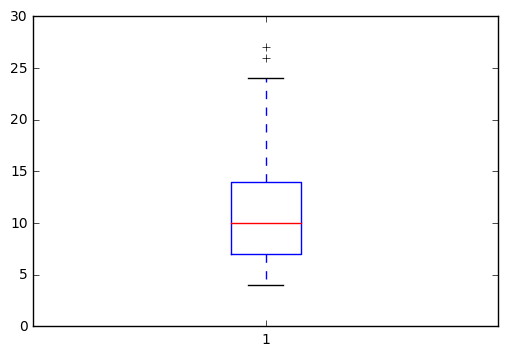

In [350]:
from matplotlib import pyplot

result = [len(x) for x in xTrain]
pyplot.boxplot(result)
pyplot.show()

It looks like a good number to capture most of the data is 20 so we'll set a constant to define that. I'll put a few other hyper parameters in here too.

In [380]:
SEQUENCE_LENGTH = 20
OUTPUT_DIM = 32

In [381]:
import keras
from keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(xTrain, maxlen=SEQUENCE_LENGTH)
X_test = pad_sequences(xTest, maxlen=SEQUENCE_LENGTH)

print X_train[0:4]
print X_test[0:4]

[[  0   0   0   0   0   0   0  98 120 201 128 123 502  98 120 201 128 123
  415 412]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 235 278 235
  278 392]
 [  0   0   0   0   0   0   0   0   0   0   0   0 146 429   3 522 263 263
  657 146]
 [  0   0   0   0   0   0   0   0   0   0   0   0  76   1  41  36  76  18
   41  36]]
[[  0   0   0   0   0   0   0  43  43 217 283 124 110   8  43  43 217 283
  124 110]
 [  0   0   0   0   0   0   0 437  34  34 113   5 404  97  71 364  34  34
  113  73]
 [  0   0   0   0   0   0   0   0   0  16  23  33 529  72 349  33  23 594
  453 343]
 [  0   0   0   0   0   0   0   0   0   0   0   0 569 640 577 558   6 422
  458 379]]


Here I'm concatenating the training and testing data into single lists. This was by mistake but I might need it later so I'm keeping it for now.

In [382]:
train = []
test = []

for num in range(len(X_train)):
    train.append([list(X_train[num]), yTrain[num]])

for num in range(len(X_test)):
    test.append([list(X_test[num]), yTest[num]])

train[4:5]

[[[0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   44,
   209,
   163,
   373,
   19,
   243,
   449,
   420,
   44,
   209,
   163,
   520],
  1]]

In [383]:
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense
from keras.layers import Flatten

model = Sequential()
model.add(Embedding(VOCABULARY_SIZE, OUTPUT_DIM, input_length=20))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_29 (Embedding)     (None, 20, 32)            21632     
_________________________________________________________________
flatten_17 (Flatten)         (None, 640)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 250)               160250    
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 251       
Total params: 182,133.0
Trainable params: 182,133.0
Non-trainable params: 0.0
_________________________________________________________________
None


convert X_train and Y_train to numpy arrays.

In [384]:
X = np.array(X_train)
Xt = np.array(X_test)
Y = np.array(yTrain)
Yt = np.array(yTest)

print X.shape
print Xt.shape
print Y.shape
print Yt.shape

(78, 20)
(25, 20)
(78,)
(25,)


In [385]:
model.fit(X, Y, validation_data=(Xt, Yt), epochs=2, batch_size=64, verbose=2)

Train on 78 samples, validate on 25 samples
Epoch 1/2
0s - loss: 0.6953 - acc: 0.4231 - val_loss: 0.6759 - val_acc: 0.6400
Epoch 2/2
0s - loss: 0.6624 - acc: 0.6795 - val_loss: 0.6642 - val_acc: 0.6400


In [386]:
scores = model.evaluate(Xt, Yt, verbose=0)
print scores

[0.66420888900756836, 0.63999998569488525]
